# Ni and Fe microspectrocopy data from BNL

In [1]:
from PIL import Image, ImageSequence
from ipywidgets import IntSlider, widgets, interactive, fixed
import itertools

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation, PillowWriter
import mplcursors
from matplotlib import gridspec
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sklearn.manifold import TSNE

In [2]:
def parse_tiff(filename):
    img = Image.open(filename)
    data = np.array(img)
    N = 0
    for i, page in enumerate(ImageSequence.Iterator(img)):
        N += 1
    Data = np.zeros((N, data.shape[0], data.shape[1]))
    for i, page in enumerate(ImageSequence.Iterator(img)):
        Data[i] = np.array(page)
    return Data

1. Fe_xanes (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of LiFe(II)PO4 (LFP), Pyrite (Pyr), StainlessSteelNP (SS) and Hematite_NP (Hem). Please note that this is unpublished data from a submitted MS

2. Ni_xanes is NMC?

(101, 320, 320)
(73, 155, 160)


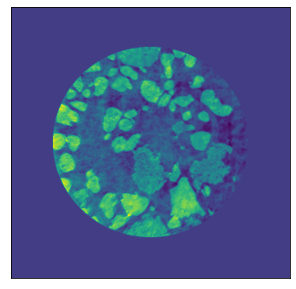

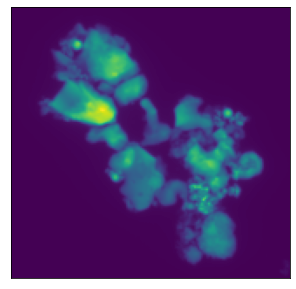

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Ni_energy = np.loadtxt('Data/TXM_XANES/Ni_eng_list.txt')

Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

# Iron References

In [5]:
def parse_nor(filename):
    data = []
    labels = []
    with open(filename) as f:
        for line in f:
            if line.startswith('#'):
                if line.startswith('# Column.'):
                    label = line.replace(f'# Column.{len(labels) + 1}: ', '').replace('\n', '')
                    labels.append(label)
                else:
                    pass
            else:
                parsed = line.replace('\n', '').split(' ')
                while "" in parsed:
                    parsed.remove('')
                parsed = [float(e) for e in parsed]
                data.append(parsed)
    f.close()
    data = np.array(data).T
    print(data.shape)
    ref_energy = data[0, :]
    Refs = data[1:, :]
    Ref_dict = {labels[i + 1]: Refs[i] for i in range(Refs.shape[0])}
    return ref_energy, Ref_dict, Refs

# Interpolating Fe XANES and Refs onto same energy grid

In [6]:
ref_energy, Refs_dict, Refs_raw = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')
energy = np.linspace(7090, 7196, 54)

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


## What normalization shoud we do?

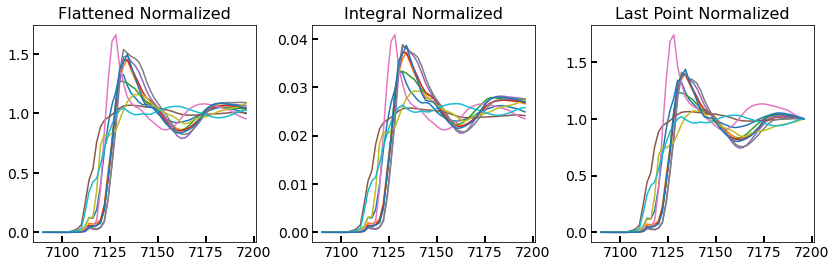

In [7]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=3)
plt.subplots_adjust(wspace=0.25)
for r in Refs:
    axes[0].plot(energy, r)
    axes[1].plot(energy, r / np.sum(r))
    axes[2].plot(energy, r / r[-1])

titles = ['Flattened Normalized', 'Integral Normalized', 'Last Point Normalized']
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=16)
    ax.tick_params(direction='in', width=2, length=6, labelsize=14)

# Begin Pipeline

In [8]:
def remove_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

def add_point_label(pickable, data, ax):
    """Add point label."""
    def onselect(sel):
        x, y = sel.target.index[0], sel.target.index[1]
        annotation = f'({x}, {y})'
        sel.annotation.set_text(annotation)
        spectrum = data[:, x, y]
        ax.clear()
        ax.plot(np.arange(len(spectrum)), spectrum, linestyle='-', linewidth=2, c=plt.cm.tab10(7))
        remove_ticks(ax)
    mplcursors.cursor(pickable, highlight=True).connect("add", onselect)

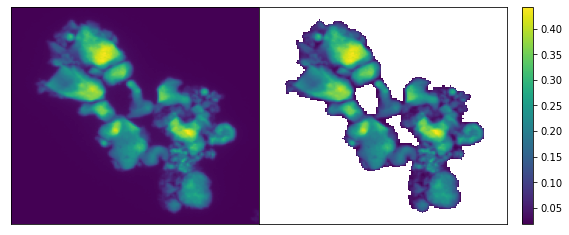

In [9]:
data = Fe_xanes

def get_filtered_img(data, threshold=0.018, return_mask=False):
    mask = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    bool_arr = np.max(Fe_xanes, axis=0) < threshold
    mask[:, bool_arr] = 1
    filtered_img = np.ma.array(data, mask=mask)
    if return_mask:
        return filtered_img, mask
    else:
        return filtered_img

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1], aspect='auto')

for ax in fig.get_axes():
    remove_ticks(ax)

plt.colorbar(img)
plt.show()

In [10]:
%matplotlib inline

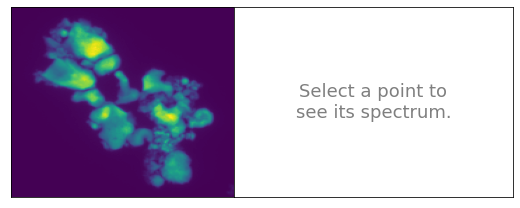

In [11]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# PCA

In [12]:
def make_scree_plot(data, n=5, threshold=0.95, show_first_PC=True, mod=0, c=0):
    fig, ax = plt.subplots(figsize=(8,6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    n_components = 0
    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    for i, val in enumerate(cdf):
        if val > threshold:
            print(f"It takes {i + 1} PCs to explain {int(threshold*100)}% variance.")
            n_components = i + 1
            break

    ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
            color=plt.cm.tab10(c))
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

    if show_first_PC:
        PC1 = pca.components_[0]
        plt.plot(np.linspace(1, n, len(PC1)), -PC1*0.3 + min(cdf) + 0.05, 'k', linewidth=2)
        text = ax.text(n - 1, min(cdf) + 0.06, '$PC_1$', ha="right", va="bottom", size=20)

    if mod == 0:
        xticks = np.arange(n) + 1
    else:
        xticks = np.arange(0, n + 1, mod)
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(min(cdf) - 0.05, 1.02)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)
    
    return n_components

In [13]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

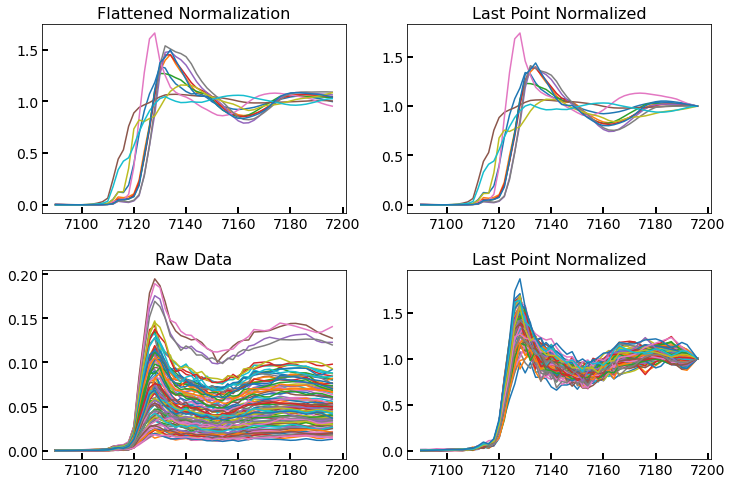

In [14]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
for r in Refs:
    axes[0, 0].plot(energy, r)
    axes[0, 1].plot(energy, r / r[-1])

titles = [['Flattened Normalization', 'Last Point Normalized'],
          ['Raw Data', 'Last Point Normalized']]
for i, subax in enumerate(axes):
    for j, ax in enumerate(subax):
        ax.set_title(titles[i][j], fontsize=16)
        ax.tick_params(direction='in', width=2, length=6, labelsize=14)

c = 0
for spectrum in filtered_spectra:
    axes[1, 0].plot(energy, spectrum)
    axes[1, 1].plot(energy, spectrum / spectrum[-1])
    c += 1
    if c > 100:
        break

## How do we properly normalize spectra?

It takes 5 PCs to explain 95% variance.


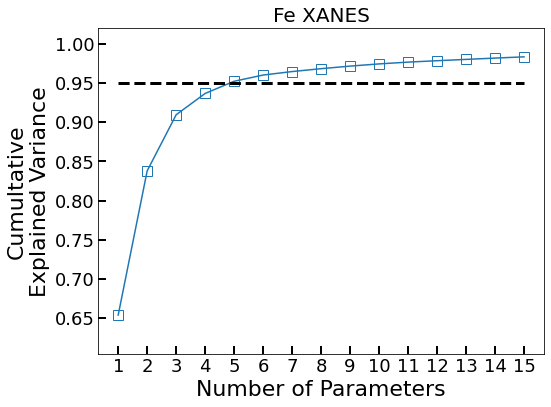

In [15]:
data = filtered_spectra

### How to properly normalize spectra???
#data = data / np.sum(data, axis=1).reshape(-1, 1)  # integral normalizing
data = data / data[:, -1].reshape(-1, 1)  # last point normalizing
n_components = make_scree_plot(data, n=15, c=0, threshold=0.95, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.show()

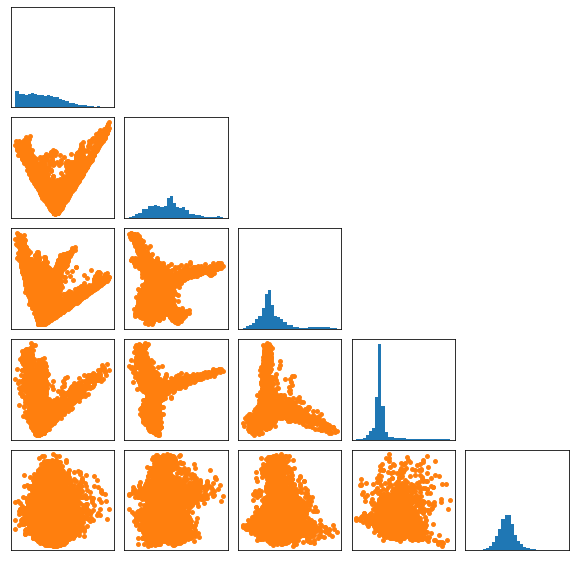

In [16]:
pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(filtered_spectra)

fig, axes = plt.subplots(figsize=(2 * n_components, 2 * n_components),
                         ncols=n_components, nrows=n_components)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in np.arange(n_components):
    for j in np.arange(n_components):
        ax = axes[i, j]
        if i == j:
            ax.hist(pca_components[:, i], color=plt.cm.tab10(0), bins=30)
            ax.set_xticks([])
            ax.set_yticks([])
        elif j < i:
            ax.scatter(pca_components[:, i], pca_components[:, j], marker='o', s=15, 
                       color=plt.cm.tab10(1))
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
            
max_y = 0
for i in np.arange(n_components):
    ax = axes[i, i]
    y_lim = ax.get_ylim()[1]
    if y_lim > max_y:
        max_y = y_lim
for i in np.arange(n_components):
    ax = axes[i, i]
    ax.set_ylim(0, max_y)

plt.show()

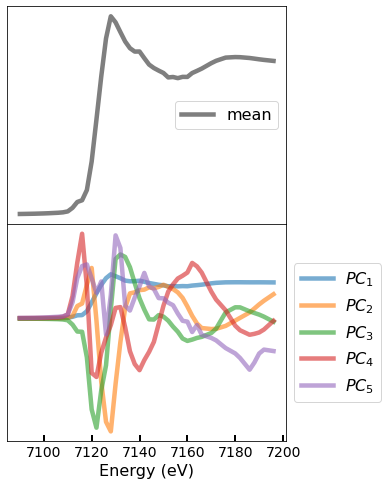

In [17]:
fig, axes = plt.subplots(figsize=(5, 8), nrows=2)
plt.subplots_adjust(hspace=0)

axes[0].plot(energy, pca.mean_, linewidth=4.5, label='mean', c=plt.cm.tab10(7))
for i, pc in enumerate(pca.components_):
    axes[1].plot(energy, pc, linewidth=4.5, alpha=0.6, label=f"$PC_{i + 1}$")

axes[0].legend(fontsize=16, loc='center right')
axes[1].legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')
for ax in axes:
    ax.tick_params(direction='in', width=2, length=6, labelsize=14)
    ax.set_yticks([])
axes[0].set_xticks([])
axes[1].set_xlabel('Energy (eV)', fontsize=16)
plt.show()

# UMAP

In [18]:
def get_translated_colors(dbscan_clustering, filtered_spectra_dict):
    points = list(filtered_spectra_dict.keys())
    point_index = {point: i for i, point in enumerate(points)}
    labels = dbscan_clustering.labels_.copy()
    
    color_codemap = {i: i for i in range(len(np.unique(labels)))}
    translation_map = {(33, 38): 14, (63, 49): 13, (60, 31): 12, (46, 69): 16,
                       (102, 70): 17, (35, 58): 4, (135, 115): 6, (89, 113): 0,
                       (54, 76): 10, (84, 120): 8}
    
    for i, point in enumerate(points):
        if point in list(translation_map.keys()):
            translated_color = translation_map[point]
            original_label = labels[point_index[point]]
            print(f'{original_label} -> {translated_color}')
            color_codemap[original_label] = translated_color
            
    translated_colors = [color_codemap[label] for label in labels]
    return translated_colors

0 -> 14
4 -> 4
2 -> 16
8 -> 10
5 -> 12
7 -> 13
2 -> 8
9 -> 0
1 -> 17
3 -> 6


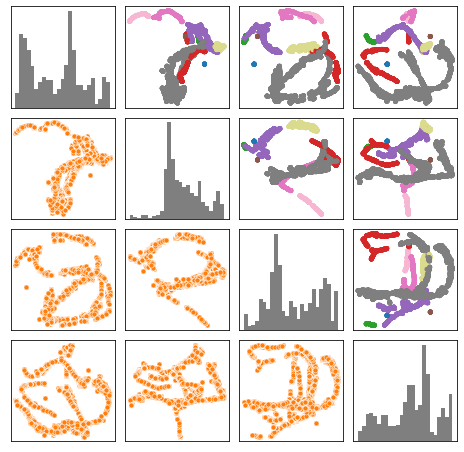

In [19]:
n_neighbors = 5
min_dist = 0.01
dimension = 4
reducer = umap.UMAP(random_state=42, n_components=dimension,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

dbscan_clustering = DBSCAN(eps=1.5, min_samples=1).fit(reduced_space)
cluster_dict = {loc: dbscan_clustering.labels_[i] for i, loc in enumerate(list(filtered_spectra_dict.keys()))}
color_labels = get_translated_colors(dbscan_clustering, filtered_spectra_dict)
colors = [plt.cm.tab20(c) for c in color_labels]

fig, axes = plt.subplots(figsize=(2 * dimension, 2 * dimension),
                         ncols=dimension, nrows=dimension)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in np.arange(dimension):
    for j in np.arange(dimension):
        ax = axes[i, j]
        if i == j:
            ax.hist(reduced_space[:, i], color=plt.cm.tab10(7), bins=25)
        elif j < i:
            ax.scatter(reduced_space[:, i], reduced_space[:, j], marker='o', s=25, 
                       color=plt.cm.tab10(1), edgecolor='w', linewidth=0.5)
        else:
            ax.scatter(reduced_space[:, j], reduced_space[:, i], marker='o', s=15, 
                       color=colors)
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

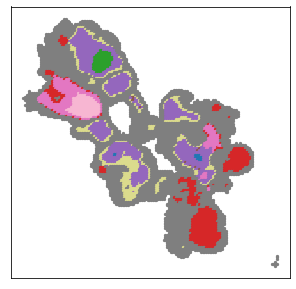

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
for i, key in enumerate(list(filtered_spectra_dict.keys())):
    spectrum = filtered_spectra_dict[key]
    x, y = key
    ax.plot(y, -x, color=plt.cm.tab20(color_labels[i]), marker='.', markersize=4.5)
remove_ticks(ax)
plt.show()

# LCF

### Cluster averages

In [21]:
clusters = {i: [] for i in np.unique(dbscan_clustering.labels_)}

for i, key in enumerate(list(filtered_spectra_dict.keys())):
    spectrum = filtered_spectra_dict[key]
    color = dbscan_clustering.labels_[i]
    clusters[color].append(spectrum)

cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}

NameError: name 'color_codemap' is not defined

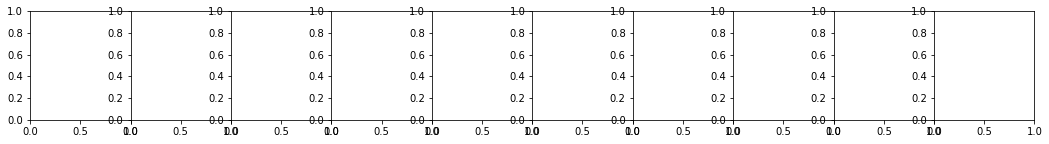

In [22]:
fig, axes = plt.subplots(figsize=(18, 2), ncols=len(clusters))
plt.subplots_adjust(wspace=0)

for i, key in enumerate(list(cluster_avgs.keys())):
    axes[i].plot(energy, cluster_avgs[key] / np.sum(cluster_avgs[key]),
                 linewidth=4.5, alpha=0.6, c=plt.cm.tab20(color_codemap[key]))

label_map = {0: 'I', 1: 'II', 2: 'III', 3: 'IV', 4: 'V', 5: 'VI', 6: 'VII', 7: 'VIII', 8: 'IX', 9: 'X'}
for i, ax in enumerate(axes):
    ax.tick_params(direction='in', width=2, length=6, labelsize=12)
    ax.set_yticks([])
    ax.set_xticks([7125, 7175])
    ax.set_xlabel('Energy (eV)', fontsize=12)
    ax.text(7175, 0.2 * ax.get_ylim()[1], label_map[i], fontsize=24, ha='center', va='center',
            c=plt.cm.tab20(color_codemap[i]))

### LCF functions and validation

In [ ]:
def chi_square(data, fit, sigma_squared=1):
    return np.sum((data - fit)**2 / sigma_squared)

def reduced_chi_square(data, fit, m, sigma_squared=1):
    dof = len(data) - m - 1
    return chi_square(data, fit, sigma_squared=sigma_squared) / dof
    
def R_score(data, fit):
    return np.sum((data - fit)**2) / np.sum(data**2)

def scale_coeffs_to_add_to_one(coeff_mtx):
    sums = [np.sum(coeffs) for coeffs in coeff_mtx]
    normalized_coeffs = np.array([coeff_mtx[i] / sums[i] for i in range(len(sums))])
    return normalized_coeffs

def objective_function(coeffs, Refs, target, lambda1, lambda2):
    calc = Refs.T @ coeffs
    calc = calc - np.min(calc)  # set min to zero
    return np.sum((calc - target)**2) \
           + lambda1 * np.sum(np.abs(coeffs)) \
           + lambda2 * (np.sum(coeffs) - 1)**2

def get_coeffs_from_spectra(spectra, Refs, lambda1=10, lambda2=1e8):
    m = Refs.shape[0]
    coeffs_0 = np.ones(m) / m
    bounds = np.zeros((m, 2))
    bounds[:, 1] = 1
    results = [minimize(objective_function, coeffs_0,
               args=(Refs, spectrum, lambda1, lambda2),
               bounds=bounds) for spectrum in spectra]
    coeffs = np.array([results[i].x for i in range(len(results))])
    return scale_coeffs_to_add_to_one(coeffs)

def get_sets_from_subset_indices(subset_indices, basis):
    subset = np.array([ele for i, ele in enumerate(basis) if i in subset_indices])
    non_subset_indices = np.array([i for i, ele in enumerate(basis) if i not in subset_indices])
    non_subset = np.array([ele for i, ele in enumerate(basis) if i not in subset_indices])
    return subset, non_subset_indices, non_subset

def get_goodness_of_fit_from_subset(subset, target, lambda1=10, lambda2=1e8):
    coeffs_hat = get_coeffs_from_spectra([target], subset, lambda1=lambda1, lambda2=lambda2)
    recon = coeffs_hat @ subset
    recon = recon.reshape(-1)
    recon = recon - np.min(recon)
    score = chi_square(target, recon)
    return score

def LCF(target, basis, subset_size, eps=1e-4, lambda1=10, lambda2=1e8, verbose=True):
    
    indices = np.arange(basis.shape[0])     
    best_score = np.inf
    best_subset_indices = np.zeros(subset_size)
    
    i = 0
    for subset_indices in itertools.combinations(indices, subset_size):
        print(i + 1, end='\r')
        subset_indices = np.array(subset_indices)
        subset, non_subset_indices, non_subset = get_sets_from_subset_indices(subset_indices, basis) 
        set_tuple = (subset, subset_indices, non_subset, non_subset_indices)
        score = get_goodness_of_fit_from_subset(subset, target, lambda1=lambda1, lambda2=lambda2)
        if score < best_score:
            best_score = score.copy()
            best_subset_indices = subset_indices.copy()
            if best_score < eps:
                break
        i += 1            
        subset_indices = best_subset_indices
        subset, _, _ = get_sets_from_subset_indices(subset_indices, basis)
    
    if verbose:
        print(subset_indices, best_score)
    coeffs_hat = get_coeffs_from_spectra([target], subset, lambda1=lambda1, lambda2=lambda2)
    return subset_indices, subset, coeffs_hat, best_score

In [ ]:
def label_ax_with_score(ax, target, pred, sub_idxs, conc, flag=False):
    R = R_score(target, pred)
    chi2 = chi_square(target, pred)
    xs = ax.get_xlim()
    ys = ax.get_ylim()
    label = '$C_{max} = ' + f'{sub_idxs}' + '_{(' + f'{int(conc * 100)}' + '\%)}$\n' \
            + '$\chi^2 = $' + f'{chi2:.03f}'
    if flag:
        c = 'red'
    else:
        c = 'k'
    ax.text(0.36 * (xs[1] - xs[0]) + xs[0], 0.12 * (ys[1] - ys[0]) + ys[0], label, 
            fontsize=16, color=c)
    
def plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Ref_Data_dict,
                    confidence=0.8, ncols=5, flag_identity=True, verbose=False, c=3):
    m = len(targets)
    preds = []
    for i in range(m):
        pred = coeffs[i] @ subsets[i]
        pred = pred - np.min(pred)
        preds.append(pred.reshape(-1))
    preds = np.array(preds) 
    
    if m % ncols == 0:
        nrows = int(m // ncols)
    else:
        nrows = int(m // ncols) + 1
    fig, axes = plt.subplots(figsize=(3.3 * ncols, 2.3 * nrows), ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0, hspace=0)

    if len(axes.shape) == 2:
        for i in range(axes.shape[0]):            
            for j in range(axes.shape[1]):
                ax = axes[i, j]
                if i * ncols + j < m:
                    ax.plot(energy, targets[i * ncols + j], '-', linewidth=3, label='target',
                            c=plt.cm.tab10(0))
                    ax.plot(energy, preds[i * ncols + j], '--', linewidth=3, label='fit',
                            c=plt.cm.tab10(c))
                    max_i = subset_indices[i * ncols + j][np.argmax(coeffs[i * ncols + j])]
                    max_conc = np.max(coeffs[i * ncols + j])
                    if (max_i != i * ncols + j or max_conc < confidence) and flag_identity:
                        flag = True
                        print(list(Ref_Data_dict.keys())[i * ncols + j])
                    else:
                        flag = False
                    label_ax_with_score(ax, targets[i * ncols + j], preds[i * ncols + j],
                                        max_i + 1, max_conc, flag=flag)
                    if (i * ncols + j + 1) % (ncols) == 0:
                        ax.legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')
                    ax.set_yticks([])
                    ax.set_xticks([])
                else:
                    ax.axis('off')
    else:
        for i, ax in enumerate(axes):
            if i < m:
                ax.plot(energy, targets[i], '-', linewidth=3, label='target', c=plt.cm.tab10(7))
                ax.plot(energy, preds[i], '--', linewidth=3, label='fit', c=plt.cm.tab10(c))
                ax.set_yticks([])
                ax.set_xticks([])
                max_i = subset_indices[i][np.argmax(coeffs[i])]
                max_conc = np.max(coeffs[i])
                if (max_i != i or max_conc < confidence) and flag_identity:
                    flag = True
                    if verbose:
                        print(list(Ref_Data_dict.keys())[i])
                else:
                    flag = False
                label_ax_with_score(ax, targets[i], preds[i],
                                    max_i + 1, max_conc, flag=flag)
                if i == m - 1:
                    ax.legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')
            else:
                ax.axis('off')

# How reliable are Refs fitted onto themselves?

In [ ]:
make_scree_plot(Refs, threshold=.95, show_first_PC=False)

In [ ]:
subset_size = 5
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = Refs 
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], targets, subset_size, lambda1=10, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

In [ ]:
plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Refs_dict,
                verbose=True, ncols=4, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

# What are the LCF results on the cluster averages?

In [ ]:
subset_size = 5
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], targets, subset_size, lambda1=10, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Refs_dict,
                ncols=4, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

In [ ]:
def plot_conc_from_subset(plot, coeffs, data_columns, subset_indices, color_codemap,
                          width=0.6):
    
    data_columns = [d.replace('_', ' ') for d in data_columns]
    m = coeffs.shape[0]
    fig, ax = plot
    ax.grid(axis='y', alpha=0.7, linewidth=2, zorder=0)
    labels = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']

    for i in range(m):
        conc_map = {subset_indices[i][num]: coeffs[i, num] for num in range(coeffs.shape[1])}
        sorted_conc_map = {idx: conc*100 for idx, conc in sorted(conc_map.items(),
                           key=lambda item: item[1], reverse=True)}
        bottoms = [np.sum(list(sorted_conc_map.values())[:tmp], axis=0)
                   for tmp in range(coeffs.shape[1])]
        keys = list(sorted_conc_map.keys())
        
        for k, conc in enumerate(list(sorted_conc_map.values())):
            key = keys[k]
            xlabel = labels[i]
            color = plt.cm.tab20(color_codemap[i])
            bottom = bottoms[k]
            rect = ax.bar(i, conc, width, zorder=2,
                          label=k, bottom=bottom,
                          fc=color, edgecolor='w', linewidth=2)
            names = [data_columns[key - 1]]
            if k == len(keys) - 1 or conc < 60:
                rot = 25
                fontsize = 16
            else:
                rot = 90
                fontsize=18
            if conc > 5:
                ax.bar_label(rect, labels=names, label_type='center', c='k',
                             fontsize=fontsize, rotation=rot)
            
    
    ax.tick_params(direction='out', width=2, length=6, which='major', axis='both')
    ax.set_ylabel('Concentration (%)', fontsize=20)
    ax.set_xticks(np.arange(0, m))
    ax.set_xticklabels(labels, fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    

fig, ax = plt.subplots(figsize=(len(clusters) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, color_codemap)

In [ ]:
list(Refs_dict.keys())